In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, RANSACRegressor, TheilSenRegressor

In [4]:
data_dir = 'C:/crs/proj/2025_shoreline_fits/'
fn = 'Northshore_LT_intersects.csv'
df = pd.read_csv(data_dir+fn)

# Convert to datetime format
df["date"] = pd.to_datetime(df["ShorelineI"], format="%m/%d/%Y")

# Function to convert datetime to decimal year
def datetime_to_decimal_year(dt):
    year = dt.year
    start_of_year = pd.Timestamp(f"{year}-01-01")
    end_of_year = pd.Timestamp(f"{year+1}-01-01")
    decimal_year = year + (dt - start_of_year).total_seconds() / (end_of_year - start_of_year).total_seconds()
    return decimal_year

# Apply function to convert each date
df["decimal_year"] = df["date"].apply(datetime_to_decimal_year)
df

,FID,OBJECTID,TransectID,TransOrder,BaselineID,ShorelineI,Distance,IntersectX,IntersectY,Uncertaint,Bias_Dista,BIAS,BIAS_X,BIAS_Y,Bias_Uncer,date,decimal_year
0,0,1,1,1,1,07/01/1855,34.976190,352128.892960,4.750413e+06,10.80,41.522127,6.545937,352135.016503,4.750410e+06,11.257508,1855-07-01,1855.495890
1,1,2,1,1,1,07/01/1953,-27.896967,352070.076869,4.750435e+06,10.80,-21.351030,6.545937,352076.200410,4.750432e+06,11.257508,1953-07-01,1953.495890
2,2,3,1,1,1,09/30/2000,37.442543,352131.200165,4.750412e+06,2.26,37.442543,6.545937,352131.200165,4.750412e+06,2.260000,2000-09-30,2000.745902
3,3,4,2,2,1,07/01/1855,16.848559,352094.265039,4.750372e+06,10.80,23.394496,6.545937,352100.388583,4.750370e+06,11.257508,1855-07-01,1855.495890
4,4,5,2,2,1,07/01/1944,4.646185,352082.850052,4.750376e+06,10.80,11.192122,6.545937,352088.973596,4.750374e+06,11.257508,1944-07-01,1944.497268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27231,27231,27036,3740,3740,39,07/01/1893,-2.350970,337344.903873,4.691653e+06,10.80,-2.349970,0.001000,337344.902916,4.691653e+06,10.800000,1893-07-01,1893.495890
27232,27232,27037,3740,3740,39,07/01/1938,-11.054914,337353.232937,4.691656e+06,10.80,-11.053914,0.001000,337353.231980,4.691656e+06,10.800000,1938-07-01,1938.495890
27233,27233,27038,3740,3740,39,07/01/1978,-10.946378,337353.129075,4.691656e+06,5.10,-10.945378,0.001000,337353.128118,4.691656e+06,5.100000,1978-07-01,1978.495890
27234,27234,27039,3740,3740,39,10/01/1994,-5.199820,337347.630023,4.691654e+06,5.10,-5.198820,0.001000,337347.629066,4.691654e+06,5.100000,1994-10-01,1994.747945


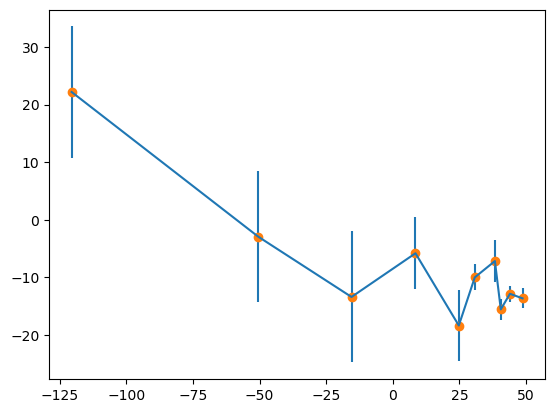

In [32]:
# pick a transect
tid = 2775
tdf = df[df["TransectID"] == tid]
x = tdf['decimal_year'].values - 1970.
y = tdf['Bias_Dista'].values
yu = tdf['Bias_Uncer'].values
plt.errorbar(x,y,yu)
plt.plot(x, y, 'o')

In [22]:
tdf['decimal_year'].values

array([1849.49589041, 1919.49589041, 1954.49589041, 1978.49589041,
       1994.74794521, 2000.74590164, 2008.28961749, 2010.50136986,
       2013.9369863 , 2018.66575342])

In [19]:
estimators = [
    ("OLS", LinearRegression()),
    ("Theil-Sen", TheilSenRegressor(random_state=42)),
    ("RANSAC", RANSACRegressor(random_state=42)),
]
colors = {"OLS": "brown", "Theil-Sen": "wheat", "RANSAC": "lavender"}
lw = 2

In [37]:
estimators[2]

('RANSAC', RANSACRegressor(random_state=42))

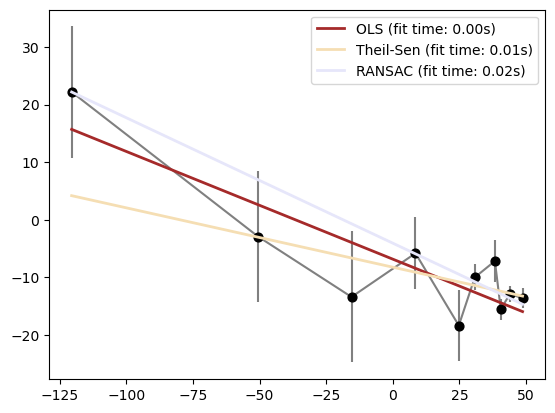

In [35]:
plt.errorbar(x, y, yu, c='gray', zorder=0)
plt.scatter(x, y, color="black", marker="o", s=40, zorder=1)
X = x[:, np.newaxis]
line_x = np.array([np.min(x), np.max(x)])
for name, estimator in estimators:
    t0 = time.time()
    reg = estimator.fit(X, y)
    elapsed_time = time.time() - t0
    y_pred = estimator.predict(line_x.reshape(2, 1))
    plt.plot(
        line_x,
        y_pred,
        color=colors[name],
        linewidth=lw,
        label="%s (fit time: %.2fs)" % (name, elapsed_time),
    )
plt.axis("tight")
plt.legend(loc="upper right")

LinregressResult(slope=np.float64(-0.18701873706402805), intercept=np.float64(-6.852459304409841), rvalue=np.float64(-0.87432805513559), pvalue=np.float64(0.0009351605608834172), stderr=np.float64(0.03670351717755362), intercept_stderr=np.float64(1.883984937888607))


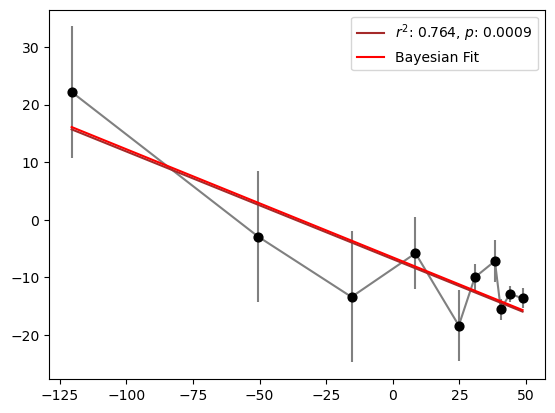

In [44]:
from scipy import stats
res = stats.linregress( x, y )
txt = r'$r^2$: {:.3f}, $p$: {:.4f}'.format( res.rvalue**2, res.pvalue )
print(res)
plt.errorbar(x, y, yu, c='gray', zorder=0)
plt.scatter(x, y, color="black", marker="o", s=40, zorder=1)
plt.plot(x, res.intercept + res.slope*x, c = 'brown', label = txt )
# need to run the next cell for this to work
plt.plot(x, slope_post * x + intercept_post, color="r", label="Bayesian Fit")
plt.legend()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 40 seconds.


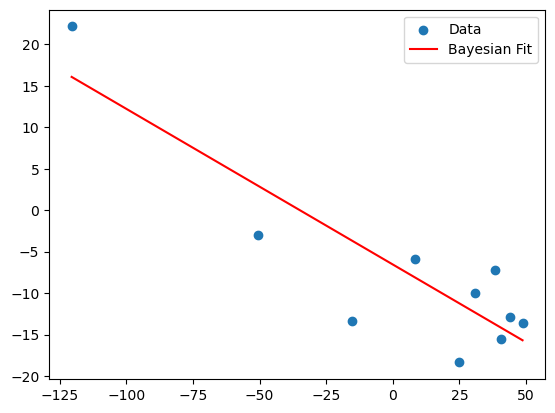

In [43]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)


# Define Bayesian Model
with pm.Model() as model:
    # Priors for slope and intercept
    slope = pm.Normal("slope", mu=0, sigma=10)
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=5)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=slope * x + intercept, sigma=sigma, observed=y)

    # Sampling
    trace = pm.sample(2000, return_inferencedata=True)

# Extract posterior mean estimates
slope_post = trace.posterior["slope"].mean().values
intercept_post = trace.posterior["intercept"].mean().values

# Plot result
plt.scatter(x, y, label="Data")
plt.plot(x, slope_post * x + intercept_post, color="r", label="Bayesian Fit")
plt.legend()
plt.show()
